<a href="https://colab.research.google.com/github/jbmarti8/jbmarti8.github.io/blob/main/Airbnb_Listing_Prices_Business_Case_ML_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Airbnb Listing Price Prediction

This code goes through the steps of the predictive modeling process: data ingestion, cleaning, feature engineering, model building, and model selection. The ultimate output will be a ML model that predicts nightly listing price for an Airbnb listing based on a number of listing-specific characteristics

In [ ]:
# Import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

###Step 1 - Import Data

Read the data in from csv files saved on Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# Import the train data
train = pd.read_csv('/content/drive/MyDrive/UW GENBUS 888 - Machine Learning/Week 8/Data/dataSP25.csv')
train.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1,Clinton Hill Apartment Single Bedroom ! Pratt ~~,30610258,Santiago,Brooklyn,Clinton Hill,40.69591,-73.96284,Private room,58,2,1,9/23/2018,0.10,1,0
1,2,Andy Phillips,6180052,Andrian,Brooklyn,Fort Greene,40.68769,-73.97490,Private room,99,5,4,9/29/2017,0.17,1,250
2,3,"Stylish, Comfortable, and Affordable in Brooklyn",5957027,Zachary,Brooklyn,Crown Heights,40.67667,-73.91750,Entire home/apt,180,2,126,6/14/2019,3.74,1,74
3,4,15 min train ride to Times Sq and US OPEN,101602599,M,Queens,Woodside,40.74340,-73.90588,Entire home/apt,50,1,95,6/24/2019,5.63,2,0
4,5,Sunny 2 bdrm Park Slope Apt w/ Yard 3min to Su...,106168581,Jason,Brooklyn,South Slope,40.66600,-73.99020,Entire home/apt,210,4,88,7/4/2019,4.41,1,20


In [ ]:
# Import the test data
test = pd.read_csv('/content/drive/MyDrive/UW GENBUS 888 - Machine Learning/Week 8/Data/compSP25.csv')
test.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1,Creative Vintage Loft in S. Williamsburg,806774,Ali & SweetPea,Brooklyn,Williamsburg,40.70667,-73.96524,Entire home/apt,2,86,5/16/2019,0.89,2,15
1,2,"2 beds in nice rooms, JFK&LGA 15 minutes",101657794,Dr. Shirin,Queens,Briarwood,40.70988,-73.80691,Private room,2,38,6/16/2019,1.53,6,365
2,3,1 Bedroom Apartment Near ESB,211549023,Studioplus,Manhattan,Midtown,40.74747,-73.98668,Entire home/apt,2,7,6/13/2019,0.84,13,276
3,4,Cozy Groundfloor Apartment w/Garden,22169347,Laura,Brooklyn,Crown Heights,40.67580,-73.95578,Entire home/apt,4,6,8/27/2018,0.16,1,0
4,5,Noho High Rise w/ Private Terrace,221071115,Ty,Manhattan,Greenwich Village,40.72836,-73.99925,Entire home/apt,7,0,NaN,NaN,1,80


In [ ]:
# Create a col train_test to differentiate these two tables when we combine for cleaning
train['train_test'] = 'train'
test['train_test'] = 'test'

###Step 2 - Scope and Clean Data

In [ ]:
# Check dtypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27379 entries, 0 to 27378
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              27379 non-null  int64  
 1   name                            27370 non-null  object 
 2   host_id                         27379 non-null  int64  
 3   host_name                       27369 non-null  object 
 4   neighbourhood_group             27379 non-null  object 
 5   neighbourhood                   27379 non-null  object 
 6   latitude                        27379 non-null  float64
 7   longitude                       27379 non-null  float64
 8   room_type                       27379 non-null  object 
 9   price                           27379 non-null  int64  
 10  minimum_nights                  27379 non-null  int64  
 11  number_of_reviews               27379 non-null  int64  
 12  last_review                     

In [ ]:
# Convert last_review to a date
train['last_review'] = pd.to_datetime(train['last_review'])

In [ ]:
# Check Summary stats for numeric vars
train.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,27379.000000,2.737900e+04,27379.000000,27379.000000,27379.000000,27379.000000,27379.000000,21746,21746.000000,27379.000000,27379.000000
mean,13690.000000,6.820276e+07,40.728836,-73.952071,151.569561,7.056722,23.228131,2018-10-02 02:45:16.968638208,1.383797,7.228788,113.430293
min,1.000000,2.438000e+03,40.506410,-74.242850,0.000000,1.000000,0.000000,2011-03-28 00:00:00,0.010000,1.000000,0.000000
25%,6845.500000,7.971896e+06,40.689955,-73.983080,69.000000,1.000000,1.000000,2018-07-06 06:00:00,0.190000,1.000000,0.000000
50%,13690.000000,3.114212e+07,40.723030,-73.955700,105.000000,3.000000,5.000000,2019-05-19 00:00:00,0.720000,1.000000,45.000000
75%,20534.500000,1.074344e+08,40.763045,-73.935830,175.000000,5.000000,23.000000,2019-06-23 00:00:00,2.030000,2.000000,230.000000
max,27379.000000,2.743213e+08,40.913060,-73.717950,10000.000000,999.000000,607.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000
std,7903.780846,7.910462e+07,0.054629,0.046278,219.807784,20.194945,44.281418,NaN,1.714116,33.173634,132.039807


####Handle Outlier Values
For numerical vars, cap outlier values at the 95th percentile value.

In [ ]:
# Create list of numerical cols
numeric_cols = train.select_dtypes(include=['number']).columns.tolist()

# Drop IDs and price cols
numeric_cols.remove('id')
numeric_cols.remove('host_id')
numeric_cols.remove('price')

In [ ]:
numeric_cols

['latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [ ]:
# Define functions to calculate thresholds, replace outliers, and verify the replacements worked

# Set thresholds
def thresholds(df, col, q1=0.05, q3=0.95):
    quartile1 = df[col].quantile(q1)
    quartile3 = df[col].quantile(q3)

    interquantile_range = quartile3 - quartile1

    ub = quartile3 + 1.5 * interquantile_range
    lb = quartile1 - 1.5 * interquantile_range

    return lb, ub

# Replace outlier values
def replace(df, var):
    lb, ub = thresholds(df, var)
    df.loc[(df[var] < lb), var] = lb
    df.loc[(df[var] > ub), var] = ub

# Assign outlier to value in data
def check_outlier(df, col):
    low_limit, up_limit = thresholds(df, col)
    if df[(df[col] > up_limit) | (df[col] < low_limit)].shape[0] > 0:
        return True
    else:
        return False

In [ ]:
# Override outlier values with the upper bound quartile value
for var in numeric_cols:
  replace(train, var)

<ipython-input-94-301882ad1a61>:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-42.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[var] < lb), var] = lb


In [ ]:
for var in numeric_cols:
  print(var,": ",check_outlier(train, var))

latitude :  False
longitude :  False
minimum_nights :  False
number_of_reviews :  False
reviews_per_month :  False
calculated_host_listings_count :  False
availability_365 :  False


Now that outlier values in the train data have been handled, combine the train and test datasets for the rest of the data cleaning steps

In [ ]:
# Combine the train and test data, reset the index
comb = pd.concat([train, test], axis=0).reset_index(drop=True)

###Handle Null Values

In [ ]:
# Check for null values by var
for col in comb.columns:
  if comb[col].isnull().sum() > 0:
    print(col,": ", comb[col].isnull().sum(), train[col].dtype)

name :  9 object
host_name :  14 object
price :  6847 int64
last_review :  7008 datetime64[ns]
reviews_per_month :  7008 float64


For the missing reviews, fill in the last_review with the min date and fill reviews_per_month with a 0

In [ ]:
# Fill null reviews_per_month with 0
comb['reviews_per_month'].fillna(0, inplace=True)

<ipython-input-99-d863227415b1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  comb['reviews_per_month'].fillna(0, inplace=True)


In [ ]:
na_check = comb.loc[comb['last_review'].isnull()]
na_check.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,train_test
10,11,NEW SUNNY PEACEFUL ROOM in Prime Williamsburg,8119817,Mila,Brooklyn,Williamsburg,40.71821,-73.94116,Private room,115.0,2.0,0,NaT,0.0,2,121,train
17,18,*NO GUEST SERVICE FEE* Beekman Tower One Bedro...,205031545,Red Awning,Manhattan,Midtown,40.75403,-73.96714,Entire home/apt,714.0,28.0,0,NaT,0.0,36,250,train
27,28,SOUTH SLOPE Brooklyn - Bright and Spacious Bed...,7007654,Dhwani,Brooklyn,Sunset Park,40.65976,-73.99191,Private room,35.0,2.0,0,NaT,0.0,1,0,train
32,33,Small Comfy space,104028121,Diana,Manhattan,Washington Heights,40.85044,-73.93042,Private room,41.0,1.0,0,NaT,0.0,1,38,train
46,47,"Wonderful 3 people room near M,J, L,G trains",248161322,Sergii,Brooklyn,Bushwick,40.70028,-73.93952,Shared room,35.0,30.0,0,NaT,0.0,14,333,train


In [ ]:
comb['last_review'] = pd.to_datetime(comb['last_review'], errors='coerce')

# Fill null values with the minimum valid datetime value
comb['last_review'].fillna(comb['last_review'].min(), inplace=True)

<ipython-input-101-d9f5a372a951>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  comb['last_review'].fillna(comb['last_review'].min(), inplace=True)


In [ ]:
# Check nulls again
for col in comb.columns:
  if comb[col].isnull().sum() > 0:
    print(col,": ", comb[col].isnull().sum(), train[col].dtype)

name :  9 object
host_name :  14 object
price :  6847 int64


Name and Host name will be dropped for the modeling, and the missing price values are the values we will be estimating, so nulls are now handled.

####Check for any strange string data.

In [ ]:
# Drop name and host_name
comb.drop(['name', 'host_name'], axis=1, inplace=True)

In [ ]:
for col in comb.columns:
  if comb[col].dtype == 'object':
    print(comb[col].value_counts())

neighbourhood_group
Manhattan        15146
Brooklyn         14098
Queens            3972
Bronx              761
Staten Island      249
Name: count, dtype: int64
neighbourhood
Williamsburg                 2720
Bedford-Stuyvesant           2597
Harlem                       1831
Bushwick                     1731
Upper West Side              1383
Hell's Kitchen               1376
East Village                 1284
Upper East Side              1258
Crown Heights                1117
Midtown                      1113
East Harlem                   786
Greenpoint                    767
Chelsea                       764
Washington Heights            647
Astoria                       640
Lower East Side               616
Financial District            538
West Village                  525
Flatbush                      451
Clinton Hill                  387
Prospect-Lefferts Gardens     365
Park Slope                    352
East Flatbush                 352
Long Island City              352
Fort Gree

There are some neighborhoods that only appear once, we will consolidate these later in feature engineering.

###Step 3 - Prepare Data for Analysis

Now that we have cleaned the data, need to perform some further checks to ensure the data is ready for analysis. These steps include:

- Looking at distributions
- Checking for correlations
- Feature engineering
- Create Dummy Variables
- Scaling
- Splitting Data into Training and Testing Sets

####First, check the distribution of the listing price

Text(0, 0.5, 'Frequency')

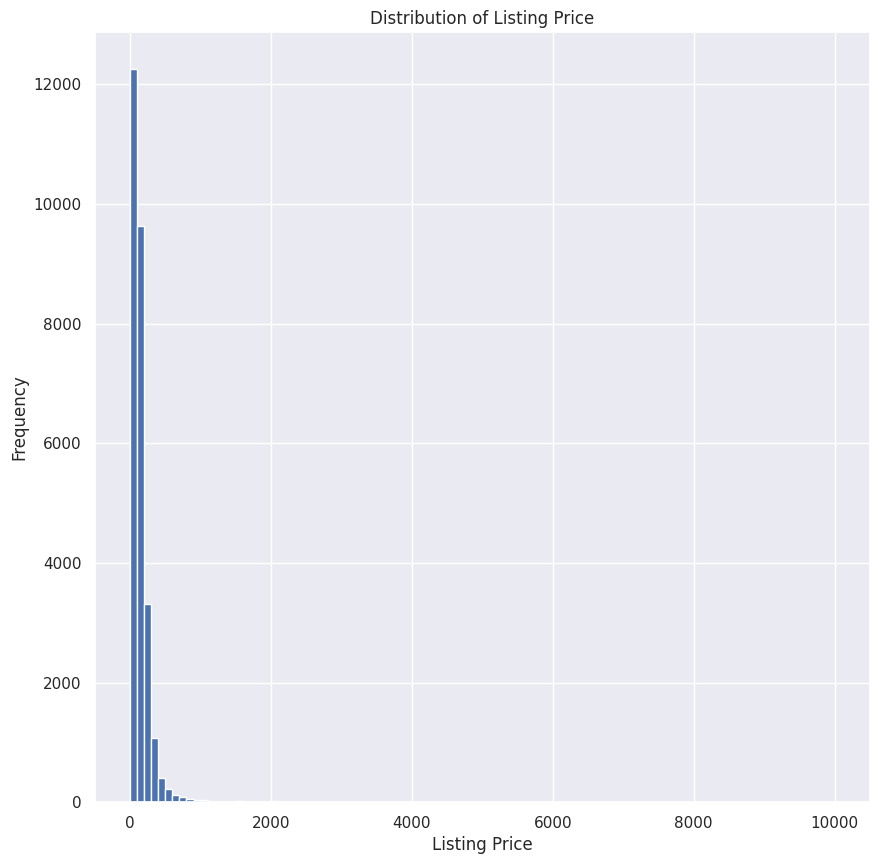

In [ ]:
# Plot histogram of SalePrice
plt.hist(comb['price'], bins = 100)
plt.title('Distribution of Listing Price')
plt.xlabel('Listing Price')
plt.ylabel('Frequency')

The distribution looks to have a heavy right-tail skew, so transform the price to be a log, this will help "normalize" the distribution a bit better.

Text(0, 0.5, 'Frequency')

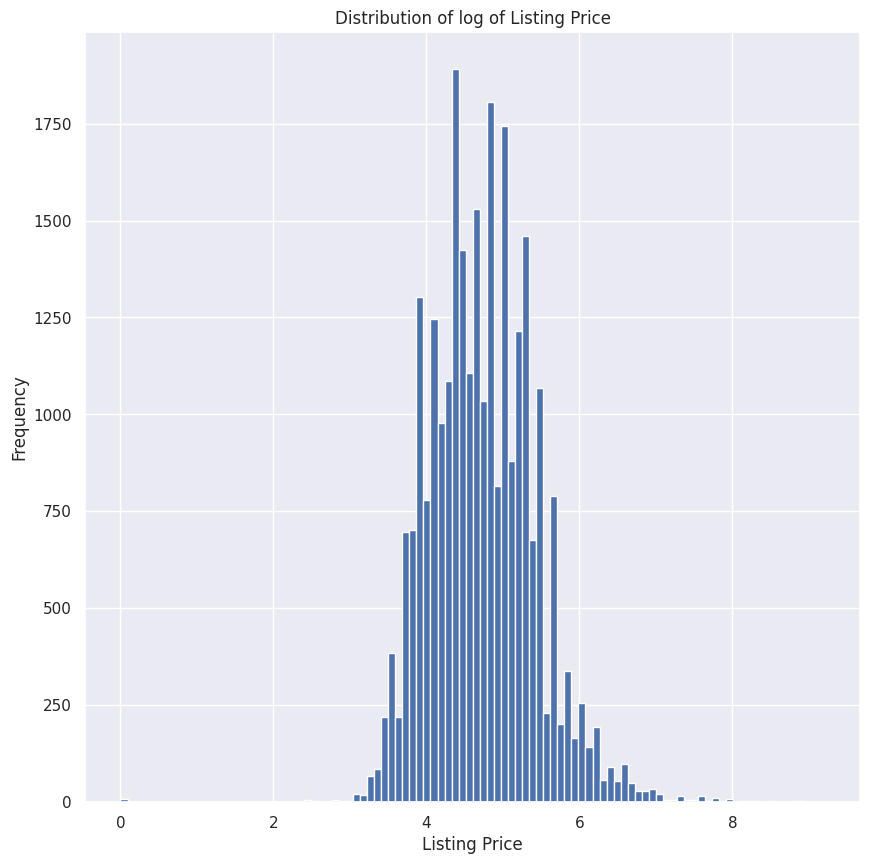

In [ ]:
# Do same plot but for log
plt.hist(np.log1p(comb['price']), bins = 100)
plt.title('Distribution of log of Listing Price')
plt.xlabel('Listing Price')
plt.ylabel('Frequency')

The log adjustment looks to normalize the distribution a bit, but there is still a decent right-side skew on the data.

####Check numeric explanatory variables for correlation

In [ ]:
# Isolate numeric vars
numeric_vars = comb.select_dtypes(include=('number'))

In [ ]:
numeric_vars = numeric_vars.drop(['id','host_id','price'], axis = 1)

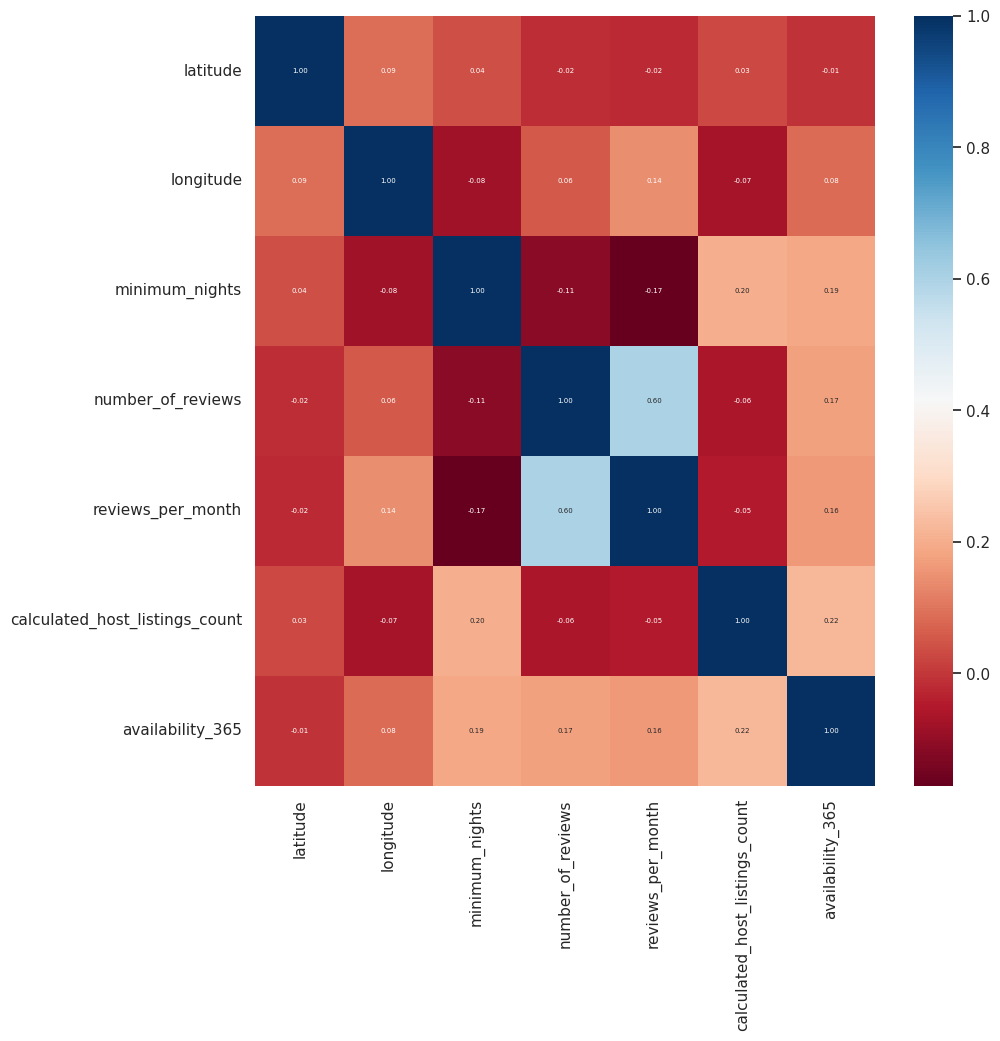

In [ ]:
# Create correlation table
corr = numeric_vars.corr()

sns.set_theme(rc={"figure.figsize":(10,10)})
sns.heatmap(corr, annot = True, fmt=".2f",cmap="RdBu",annot_kws={"size":5})
plt.show()

The only variables with somewhat high correlation are number_of_reviews and reviews_per_month, so drop reviews_per_month (we will use raw number of reviews for some feature engineering later on)

In [ ]:
# Drop highly correlated cols
comb = comb.drop('reviews_per_month', axis = 1)

###Plot Listing Price against each numerical var
Check to see if there any any non-linear relationships that could be feature engineered

In [ ]:
# Plot each numerical var against Listing Price
def plot_var_price(df, t_var):
  numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
  numeric_cols.remove(t_var)

  for col in numeric_cols:
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=df[col], y=df[t_var])
    plt.title(f'{col} vs {t_var}')
    plt.xlabel(col)
    plt.ylabel(t_var)
    plt.show()

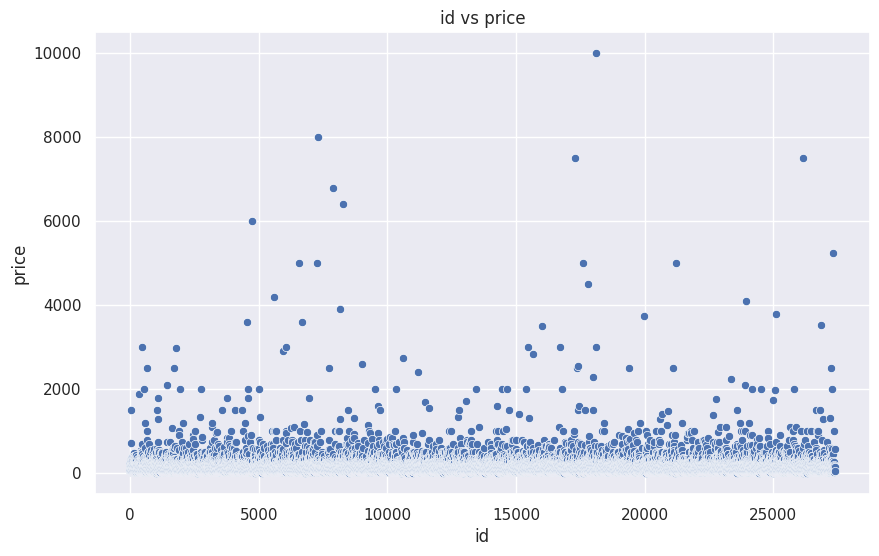

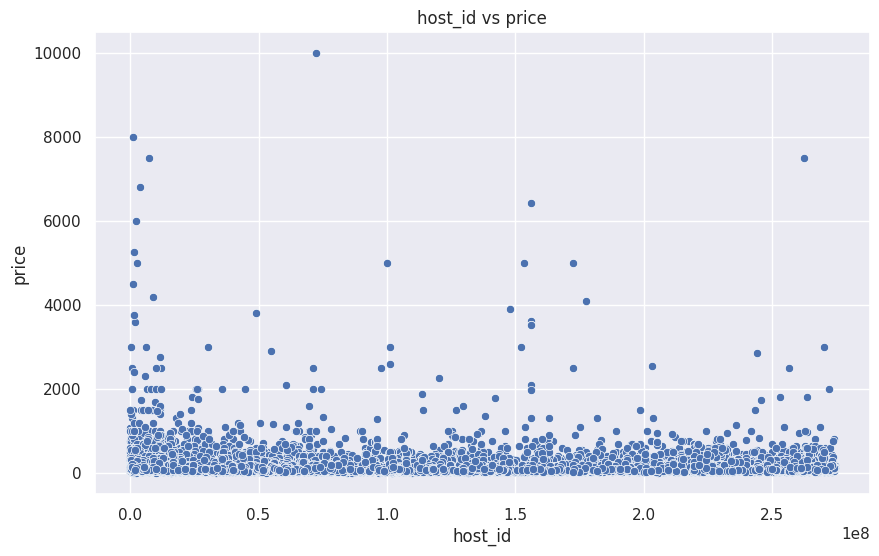

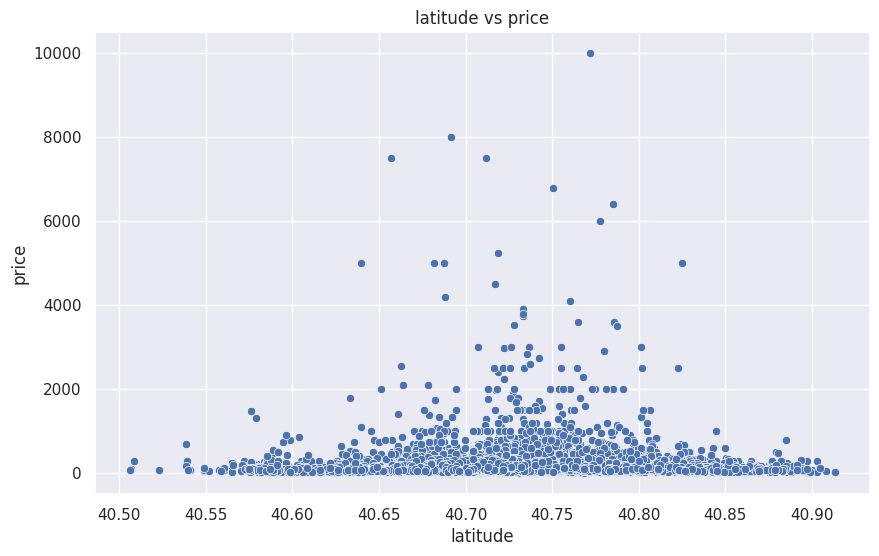

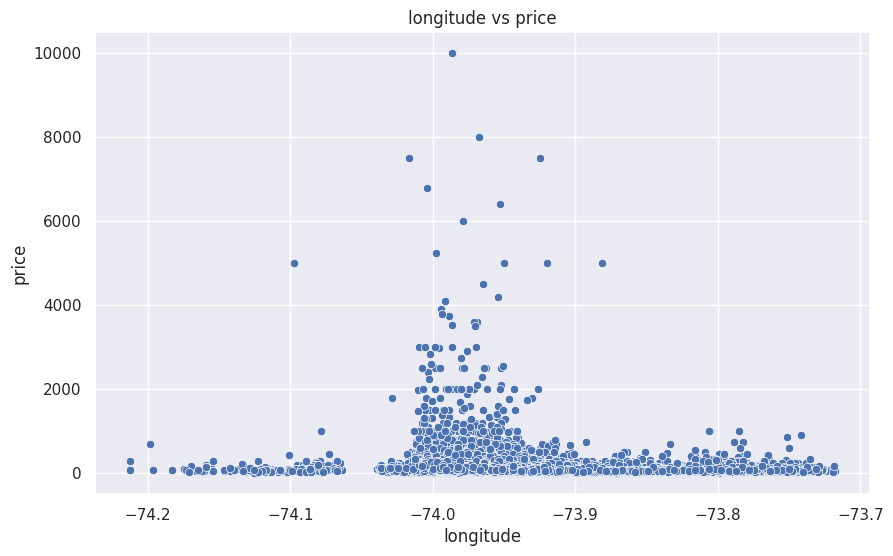

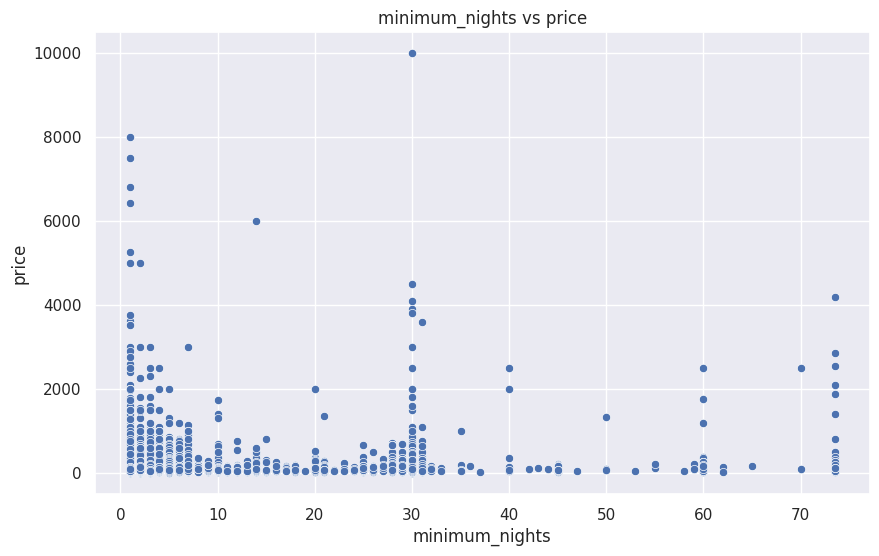

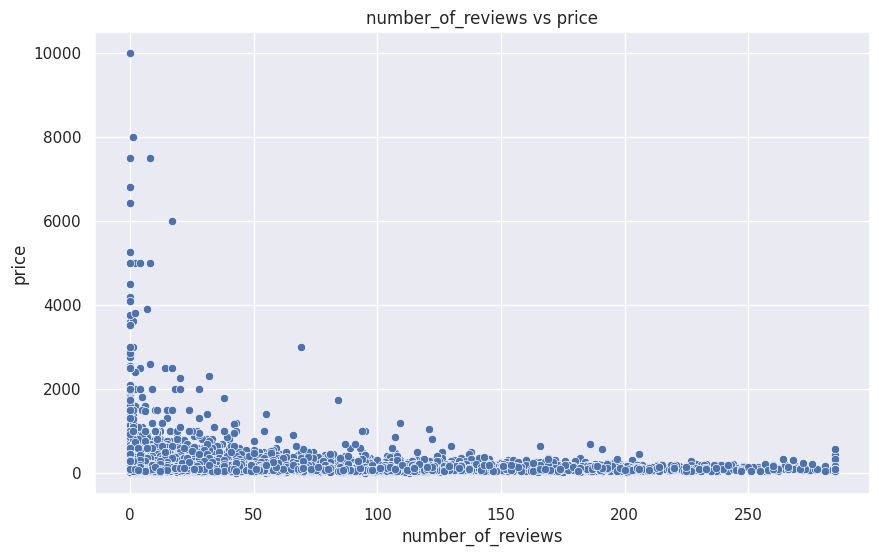

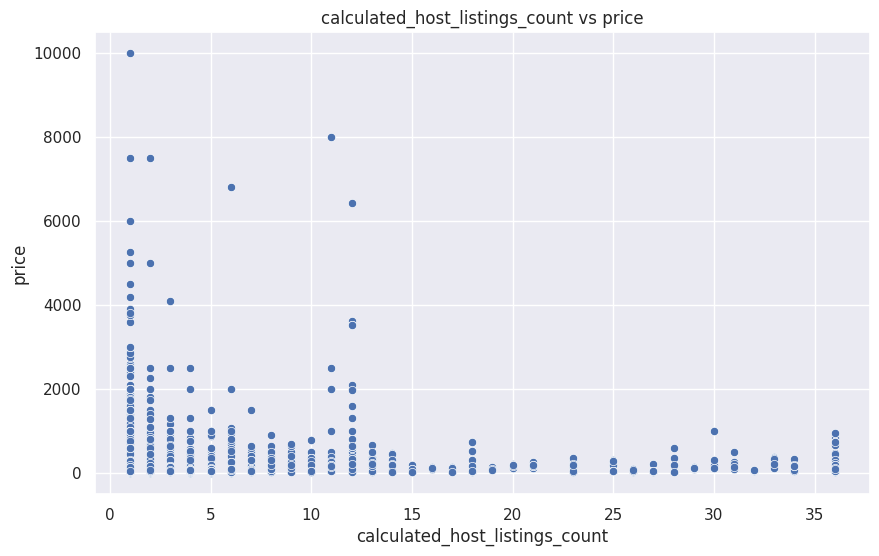

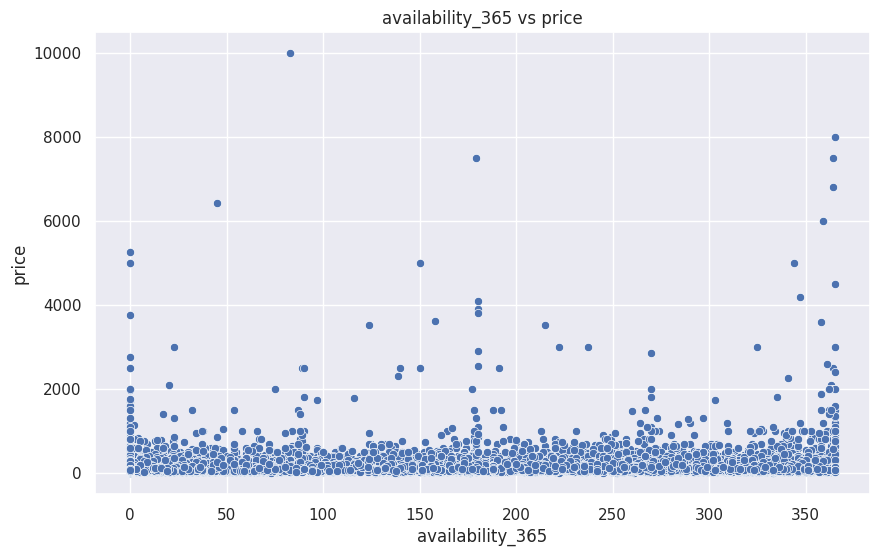

In [ ]:
# Call func
plot_var_price(comb,'price')

There don't appear to be any apparent non-linear relationships between the numeric vars and Listing Price. However, given the relationship between some of the variables, there are still a couple new features we can engineer.

On another note, we will drop latitude and longitude from the analysis, as these numerical variables have no ordinal properties, they are simply "points in space," and can be adequatley represented by the neighborhood varibale anyways.

###Numeric Variable Feature Engineering
- Use 365 availability and number of reviews to create reviews per available night. This will help to normalize the review number given the availability difference between different listings.

In [ ]:
# Function to calculate reviews per available night
def reviews_per_available_night(row):
    if row['availability_365'] == 0:
        return 0
    else:
        return row['number_of_reviews'] / row['availability_365']

# Apply the function to each row and create a new column
comb['reviews_per_available_night'] = comb.apply(reviews_per_available_night, axis=1)

- Use the max date in the data and the last review date to create days since last review

In [ ]:
comb.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365,train_test,reviews_per_available_night
0,1,30610258,Brooklyn,Clinton Hill,40.69591,-73.96284,Private room,58.0,2.0,1,2018-09-23,1,0,train,0.000000
1,2,6180052,Brooklyn,Fort Greene,40.68769,-73.97490,Private room,99.0,5.0,4,2017-09-29,1,250,train,0.016000
2,3,5957027,Brooklyn,Crown Heights,40.67667,-73.91750,Entire home/apt,180.0,2.0,126,2019-06-14,1,74,train,1.702703
3,4,101602599,Queens,Woodside,40.74340,-73.90588,Entire home/apt,50.0,1.0,95,2019-06-24,2,0,train,0.000000
4,5,106168581,Brooklyn,South Slope,40.66600,-73.99020,Entire home/apt,210.0,4.0,88,2019-07-04,1,20,train,4.400000


In [ ]:
# Take max last review
max_last_review = comb['last_review'].max()

# create days_since_last_review by subtracting last_review from max_last_review
comb['days_since_last_review'] = (max_last_review - comb['last_review']).dt.days
comb.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365,train_test,reviews_per_available_night,days_since_last_review
0,1,30610258,Brooklyn,Clinton Hill,40.69591,-73.96284,Private room,58.0,2.0,1,2018-09-23,1,0,train,0.000000,288
1,2,6180052,Brooklyn,Fort Greene,40.68769,-73.97490,Private room,99.0,5.0,4,2017-09-29,1,250,train,0.016000,647
2,3,5957027,Brooklyn,Crown Heights,40.67667,-73.91750,Entire home/apt,180.0,2.0,126,2019-06-14,1,74,train,1.702703,24
3,4,101602599,Queens,Woodside,40.74340,-73.90588,Entire home/apt,50.0,1.0,95,2019-06-24,2,0,train,0.000000,14
4,5,106168581,Brooklyn,South Slope,40.66600,-73.99020,Entire home/apt,210.0,4.0,88,2019-07-04,1,20,train,4.400000,4


Drop numerical cols not used in analysis

In [ ]:
# Now that we have feature engineered reviews_per_available_nights, we can drop the raw number of reviews, along with latitude, longitude, and last_review
comb = comb.drop(['number_of_reviews','latitude','longitude','last_review'], axis = 1)

###Categorical Variable Feature Engineering
Aggregate low neighborhood counts into the 'other' category

In [ ]:
# Take count of records by neighborhood
neighborhood_counts = comb['neighbourhood'].value_counts()
pd.set_option('display.max_rows', None)
neighborhood_counts

,count
neighbourhood,
Williamsburg,2720
Bedford-Stuyvesant,2597
Harlem,1831
Bushwick,1731
Upper West Side,1383
Hell's Kitchen,1376
East Village,1284
Upper East Side,1258
Crown Heights,1117


In [ ]:
# Map neighborhood counts back onto comb data
comb = comb.merge(neighborhood_counts, how='left', left_on='neighbourhood', right_index=True)

In [ ]:
# Override with other
comb.loc[comb['count'] < 5, 'neighbourhood'] = 'Other'

# Drop count
comb = comb.drop('count', axis = 1)

###Create Dummy Variables
Only need non-ordinal encoding for the categorical vars

In [ ]:
# Isolate numerical vars
numeric_vars = comb.select_dtypes(include=('number'))

In [ ]:
# Isolate categorical vars
categorical_vars = comb.select_dtypes(include=('object'))
categorical_vars = categorical_vars.drop(['train_test'], axis = 1)

In [ ]:
# Generate dummies
dummies = pd.get_dummies(categorical_vars, drop_first = True)

In [ ]:
# Combine numerical and dummies
comb2 = pd.concat([numeric_vars,dummies,comb['train_test']], axis = 1)
comb2.head()

,id,host_id,price,minimum_nights,calculated_host_listings_count,availability_365,reviews_per_available_night,days_since_last_review,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,neighbourhood_Cambria Heights,neighbourhood_Canarsie,neighbourhood_Carroll Gardens,neighbourhood_Castle Hill,neighbourhood_Chelsea,neighbourhood_Chinatown,neighbourhood_City Island,neighbourhood_Civic Center,neighbourhood_Claremont Village,neighbourhood_Clason Point,neighbourhood_Clifton,neighbourhood_Clinton Hill,neighbourhood_Cobble Hill,neighbourhood_College Point,neighbourhood_Columbia St,neighbourhood_Concord,neighbourhood_Concourse,neighbourhood_Concourse Village,neighbourhood_Coney Island,neighbourhood_Corona,neighbourhood_Crown Heights,neighbourhood_Cypress Hills,neighbourhood_DUMBO,neighbourhood_Ditmars Steinway,neighbourhood_Douglaston,neighbourhood_Downtown Brooklyn,neighbourhood_Dyker Heights,neighbourhood_East Elmhurst,neighbourhood_East Flatbush,neighbourhood_East Harlem,neighbourhood_East Morrisania,neighbourhood_East New York,neighbourhood_East Village,neighbourhood_Eastchester,neighbourhood_Edenwald,neighbourhood_Edgemere,neighbourhood_Elmhurst,neighbourhood_Far Rockaway,neighbourhood_Fieldston,neighbourhood_Financial District,neighbourhood_Flatbush,neighbourhood_Flatiron District,neighbourhood_Flatlands,neighbourhood_Flushing,neighbourhood_Fordham,neighbourhood_Forest Hills,neighbourhood_Fort Greene,neighbourhood_Fort Hamilton,neighbourhood_Fresh Meadows,neighbourhood_Glendale,neighbourhood_Gowanus,neighbourhood_Gramercy,neighbourhood_Grant City,neighbourhood_Gravesend,neighbourhood_Great Kills,neighbourhood_Greenpoint,neighbourhood_Greenwich Village,neighbourhood_Grymes Hill,neighbourhood_Harlem,neighbourhood_Hell's Kitchen,neighbourhood_Highbridge,neighbourhood_Hollis,neighbourhood_Howard Beach,neighbourhood_Hunts Point,neighbourhood_Inwood,neighbourhood_Jackson Heights,neighbourhood_Jamaica,neighbourhood_Jamaica Estates,neighbourhood_Jamaica Hills,neighbourhood_Kensington,neighbourhood_Kew Gardens,neighbourhood_Kew Gardens Hills,neighbourhood_Kingsbridge,neighbourhood_Kips Bay,neighbourhood_Laurelton,neighbourhood_Little Italy,neighbourhood_Long Island City,neighbourhood_Longwood,neighbourhood_Lower East Side,neighbourhood_Manhattan Beach,neighbourhood_Marble Hill,neighbourhood_Mariners Harbor,neighbourhood_Maspeth,neighbourhood_Melrose,neighbourhood_Middle Village,neighbourhood_Midtown,neighbourhood_Midwood,neighbourhood_Morningside Heights,neighbourhood_Morris Heights,neighbourhood_Morris Park,neighbourhood_Morrisania,neighbourhood_Mott Haven,neighbourhood_Mount Eden,neighbourhood_Mount Hope,neighbourhood_Murray Hill,neighbourhood_Navy Yard,neighbourhood_New Springville,neighbourhood_NoHo,neighbourhood_Nolita,neighbourhood_Norwood,neighbourhood_Other,neighbourhood_Ozone Park,neighbourhood_Park Slope,neighbourhood_Parkchester,neighbourhood_Pelham Bay,neighbourhood_Pelham Gardens,neighbourhood_Port Morris,neighbourhood_Prospect Heights,neighbourhood_Prospect-Lefferts Gardens,neighbourhood_Queens Village,neighbourhood_Randall Manor,neighbourhood_Red Hook,neighbourhood_Rego Park,neighbourhood_Richmond Hill,neighbourhood_Ridgewood,neighbourhood_Riverdale,neighbourhood_Rockaway Beach,neighbourhood_Roosevelt Island,neighbourhood_Rosedal

###Check final dataset including dummy variables for any remaining highly correlated features

In [ ]:
# Stack-rank variable pairs by correlation
def get_sorted_correlations(df, threshold):
    corr_matrix = df.corr().abs()
    corr_unstacked = corr_matrix.unstack().reset_index()
    corr_unstacked.columns = ['Variable1', 'Variable2', 'Correlation']
    corr_unstacked = corr_unstacked[corr_unstacked['Variable1'] != corr_unstacked['Variable2']]
    corr_filtered = corr_unstacked[corr_unstacked['Correlation'] >= threshold]
    sorted_corr = corr_filtered.sort_values(by='Correlation', ascending=False)
    sorted_corr = sorted_corr.drop_duplicates(subset=['Correlation'])

    return sorted_corr

In [ ]:
# Show all rows
sorted_corr = get_sorted_correlations(comb2.drop(['price','train_test'], axis = 1), 0.8)
sorted_corr

,Variable1,Variable2,Correlation


There are no variables with greater than 0.8 correlation, so no need to remove any more variables

###Scale Data

In [ ]:
# Identify numeric cols
numeric_cols = comb2.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('id')
numeric_cols.remove('host_id')
numeric_cols.remove('price')

In [ ]:
# Scale all the numeric data, except for the Id and SalePrice
scaler = StandardScaler()
comb_scaled = comb2.copy()
comb_scaled[numeric_cols] = scaler.fit_transform(comb_scaled[numeric_cols])

In [ ]:
comb_scaled.head()

,id,host_id,price,minimum_nights,calculated_host_listings_count,availability_365,reviews_per_available_night,days_since_last_review,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,neighbourhood_Cambria Heights,neighbourhood_Canarsie,neighbourhood_Carroll Gardens,neighbourhood_Castle Hill,neighbourhood_Chelsea,neighbourhood_Chinatown,neighbourhood_City Island,neighbourhood_Civic Center,neighbourhood_Claremont Village,neighbourhood_Clason Point,neighbourhood_Clifton,neighbourhood_Clinton Hill,neighbourhood_Cobble Hill,neighbourhood_College Point,neighbourhood_Columbia St,neighbourhood_Concord,neighbourhood_Concourse,neighbourhood_Concourse Village,neighbourhood_Coney Island,neighbourhood_Corona,neighbourhood_Crown Heights,neighbourhood_Cypress Hills,neighbourhood_DUMBO,neighbourhood_Ditmars Steinway,neighbourhood_Douglaston,neighbourhood_Downtown Brooklyn,neighbourhood_Dyker Heights,neighbourhood_East Elmhurst,neighbourhood_East Flatbush,neighbourhood_East Harlem,neighbourhood_East Morrisania,neighbourhood_East New York,neighbourhood_East Village,neighbourhood_Eastchester,neighbourhood_Edenwald,neighbourhood_Edgemere,neighbourhood_Elmhurst,neighbourhood_Far Rockaway,neighbourhood_Fieldston,neighbourhood_Financial District,neighbourhood_Flatbush,neighbourhood_Flatiron District,neighbourhood_Flatlands,neighbourhood_Flushing,neighbourhood_Fordham,neighbourhood_Forest Hills,neighbourhood_Fort Greene,neighbourhood_Fort Hamilton,neighbourhood_Fresh Meadows,neighbourhood_Glendale,neighbourhood_Gowanus,neighbourhood_Gramercy,neighbourhood_Grant City,neighbourhood_Gravesend,neighbourhood_Great Kills,neighbourhood_Greenpoint,neighbourhood_Greenwich Village,neighbourhood_Grymes Hill,neighbourhood_Harlem,neighbourhood_Hell's Kitchen,neighbourhood_Highbridge,neighbourhood_Hollis,neighbourhood_Howard Beach,neighbourhood_Hunts Point,neighbourhood_Inwood,neighbourhood_Jackson Heights,neighbourhood_Jamaica,neighbourhood_Jamaica Estates,neighbourhood_Jamaica Hills,neighbourhood_Kensington,neighbourhood_Kew Gardens,neighbourhood_Kew Gardens Hills,neighbourhood_Kingsbridge,neighbourhood_Kips Bay,neighbourhood_Laurelton,neighbourhood_Little Italy,neighbourhood_Long Island City,neighbourhood_Longwood,neighbourhood_Lower East Side,neighbourhood_Manhattan Beach,neighbourhood_Marble Hill,neighbourhood_Mariners Harbor,neighbourhood_Maspeth,neighbourhood_Melrose,neighbourhood_Middle Village,neighbourhood_Midtown,neighbourhood_Midwood,neighbourhood_Morningside Heights,neighbourhood_Morris Heights,neighbourhood_Morris Park,neighbourhood_Morrisania,neighbourhood_Mott Haven,neighbourhood_Mount Eden,neighbourhood_Mount Hope,neighbourhood_Murray Hill,neighbourhood_Navy Yard,neighbourhood_New Springville,neighbourhood_NoHo,neighbourhood_Nolita,neighbourhood_Norwood,neighbourhood_Other,neighbourhood_Ozone Park,neighbourhood_Park Slope,neighbourhood_Parkchester,neighbourhood_Pelham Bay,neighbourhood_Pelham Gardens,neighbourhood_Port Morris,neighbourhood_Prospect Heights,neighbourhood_Prospect-Lefferts Gardens,neighbourhood_Queens Village,neighbourhood_Randall Manor,neighbourhood_Red Hook,neighbourhood_Rego Park,neighbourhood_Richmond Hill,neighbourhood_Ridgewood,neighbourhood_Riverdale,neighbourhood_Rockaway Beach,neighbourhood_Roosevelt Island,neighbourhood_Rosedal

###Split Data into Training and Testing Sets

In [ ]:
# Isolate train dataset from combined data
train_scaled = comb_scaled[comb_scaled['train_test'] == 'train']
test_scaled = comb_scaled[comb_scaled['train_test'] == 'test']

# Create X and y vars
X = train_scaled.drop(['id','host_id','price','train_test'], axis = 1)
y = np.log1p(train_scaled['price'])

In [ ]:
# Split into training, validation, and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [ ]:
X_train.shape

(16427, 193)

In [ ]:
X_val.shape

(5476, 193)

In [ ]:
X_test.shape

(5476, 193)

###Step 4 - Model Building and Testing
 Run a few different models to assess best fit
 - Random Forest Model
 - Gradient Boost
 - Neural Network

Models will be assessed primarily on RMSE on the test data.

**Model 1: Random Forest**

In [ ]:
# Define basic Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Check performance against the training data
rf_pred_train = rf_model.predict(X_train)
rf_errors_train = y_train - rf_pred_train

# Run RMSE and R2 on training
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_pred_train))
rf_train_r2 = r2_score(y_train, rf_pred_train)

# Check performance against the test data
rf_pred_test = rf_model.predict(X_test)
rf_errors_test = y_test - rf_pred_test

# Run RMSE and R2 on test
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_test_r2 = r2_score(y_test, rf_pred_test)

print("OLS Train RMSE: ",rf_train_rmse)
print("OLS Train R2: ",rf_train_r2)
print("OLS Test RMSE: ",rf_test_rmse)
print("OLS Test R2: ",rf_test_r2)

OLS Train RMSE:  0.20533807715309677
OLS Train R2:  0.912735690497252
OLS Test RMSE:  0.4722867359999957
OLS Test R2:  0.5506372181427095


The basic Random Forest model looks to perform incredibly well against the training data, which is to be expected, but then has poorer RMSE and R2 scores against the test data.

While the overall performance is decent, lets see if we can improve upon it. Becuase Random Forest models are not highly sensitive to tuning, instead of trying to improve the RF model, move on to a new ML model.

**Model 2 - Gradient Boosting**

In [ ]:
# Define basic Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [ ]:
# Check performance against the training data
gb_pred_train = gb_model.predict(X_train)
gb_errors_train = y_train - gb_pred_train

# Run RMSE and R2 on training
gb_train_rmse = np.sqrt(mean_squared_error(y_train, gb_pred_train))
gb_train_r2 = r2_score(y_train, gb_pred_train)

# Check performance against the test data
gb_pred_test = gb_model.predict(X_test)
gb_errors_test = y_test - gb_pred_test

# Run RMSE and R2 on test
gb_test_rmse = np.sqrt(mean_squared_error(y_test, gb_pred_test))
gb_test_r2 = r2_score(y_test, gb_pred_test)

print("GB Train RMSE: ",gb_train_rmse)
print("GB Train R2: ",gb_train_r2)
print("GB Test RMSE: ",gb_test_rmse)
print("GB Test R2: ",gb_test_r2)

GB Train RMSE:  0.45460967543832786
GB Train R2:  0.5722647679867482
GB Test RMSE:  0.4677084517053182
GB Test R2:  0.5593071161700574


The basic Gradient Boost model performs slightly better than the random forest, but lets see if we can improve it with some additional tuning.

The two parameters we can tinker with are the number of trees and the leaning rate. As the number of trees increases, variance decreaes, but bias increases. As the leaning reate increases, variance increases, and bias decreases.

In [ ]:
# Loop through a series of leanring rates and tree sizes
tree_count_list = [50,100,500,1000]
learning_rate_list = [0.01,0.05,0.075,0.1]

for tree_count in tree_count_list:
  for learning_rate in learning_rate_list:
    gb_model = GradientBoostingRegressor(n_estimators=tree_count, learning_rate=learning_rate, random_state=42)
    gb_model.fit(X_train, y_train)

    # Fit to the validation data
    gb_pred_val = gb_model.predict(X_val)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val, gb_pred_val))

    # Print results
    print(f"Tree Count: {tree_count}, Learning Rate: {learning_rate}, RMSE: {rmse}")

Tree Count: 50, Learning Rate: 0.01, RMSE: 0.5714673071079275
Tree Count: 50, Learning Rate: 0.05, RMSE: 0.4799995723155389
Tree Count: 50, Learning Rate: 0.075, RMSE: 0.46791002692668027
Tree Count: 50, Learning Rate: 0.1, RMSE: 0.46123670825495333
Tree Count: 100, Learning Rate: 0.01, RMSE: 0.5228183694242894
Tree Count: 100, Learning Rate: 0.05, RMSE: 0.46127671164790246
Tree Count: 100, Learning Rate: 0.075, RMSE: 0.4547312037866353
Tree Count: 100, Learning Rate: 0.1, RMSE: 0.4501232077222052
Tree Count: 500, Learning Rate: 0.01, RMSE: 0.4620029290333415
Tree Count: 500, Learning Rate: 0.05, RMSE: 0.4418282167131739
Tree Count: 500, Learning Rate: 0.075, RMSE: 0.4413642866754214
Tree Count: 500, Learning Rate: 0.1, RMSE: 0.4406574780903936
Tree Count: 1000, Learning Rate: 0.01, RMSE: 0.4513845643289465
Tree Count: 1000, Learning Rate: 0.05, RMSE: 0.4400657067375715
Tree Count: 1000, Learning Rate: 0.075, RMSE: 0.44041980644572193
Tree Count: 1000, Learning Rate: 0.1, RMSE: 0.44101

The best parameters are 1000 trees with a learning rate of 0.05, so use this combination to predict on the test data.

In [ ]:
# Fit new gb model
gb_model_tuned = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
gb_model_tuned.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=1000,
                          random_state=42)

In [ ]:
# Check performance against the training data
gb_tuned_pred_train = gb_model_tuned.predict(X_train)
gb_tuned_errors_train = y_train - gb_tuned_pred_train

# Run RMSE and R2 on training
gb_tuned_train_rmse = np.sqrt(mean_squared_error(y_train, gb_tuned_pred_train))
gb_tuned_train_r2 = r2_score(y_train, gb_tuned_pred_train)

# Check performance against the test data
gb_tuned_pred_test = gb_model_tuned.predict(X_test)
gb_tuned_errors_test = y_test - gb_tuned_pred_test

# Run RMSE and R2 on test
gb_tuned_test_rmse = np.sqrt(mean_squared_error(y_test, gb_tuned_pred_test))
gb_tuned_test_r2 = r2_score(y_test, gb_tuned_pred_test)

print("GB Tuned Train RMSE: ",gb_tuned_train_rmse)
print("GB Tuned Train R2: ",gb_tuned_train_r2)
print("GB Tuned Test RMSE: ",gb_tuned_test_rmse)
print("GB Tuned Test R2: ",gb_tuned_test_r2)

GB Tuned Train RMSE:  0.42823727271888706
GB Tuned Train R2:  0.6204520903019288
GB Tuned Test RMSE:  0.45985023172238587
GB Tuned Test R2:  0.5739913462186719


The tuned model improves slightly upon the untuned for both RMSE and R2. Now try a neural network model.

**Model 3 - Neural Network**

Run a sequential model with two hidden layers, and a linear output layer

In [ ]:
# Create model
nn_model = Sequential()
nn_model.add(Dense(100, input_dim=X_train.shape[1], activation='relu', name = 'layer1'))
nn_model.add(Dense(50, activation='relu', name = 'layer2'))
nn_model.add(Dense(1, activation='linear', name='output'))

# Compile model
nn_model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
nn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 100)                 │          19,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,501 (95.71 KB)

 Trainable params: 24,501 (95.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit to the training data, reserving 20% for validation
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.2416 - val_loss: 0.2644
Epoch 2/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2506 - val_loss: 0.2449
Epoch 3/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2348 - val_loss: 0.2352
Epoch 4/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2274 - val_loss: 0.2322
Epoch 5/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2046 - val_loss: 0.2408
Epoch 6/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2030 - val_loss: 0.2312
Epoch 7/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2138 - val_loss: 0.2302
Epoch 8/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2036 - val_loss: 0.2432
Epoch 9/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2105 - val_loss: 0.2338
Epoch 10/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2039 - val_loss: 0.2306
Epoch 11/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2072 - val_loss: 0.2301
Epoch 12/100
411/411 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Check performance against the training data
nn1_pred_train = nn_model.predict(X_train)

# Run RMSE and R2 on training
nn1_train_rmse = np.sqrt(mean_squared_error(y_train, nn1_pred_train))
nn1_train_r2 = r2_score(y_train, nn1_pred_train)

# Check performance against the test data
nn1_pred_test = nn_model.predict(X_test)

# Run RMSE and R2 on test
nn1_test_rmse = np.sqrt(mean_squared_error(y_test, nn1_pred_test))
nn1_test_r2 = r2_score(y_test, nn1_pred_test)

print("NN1 Train RMSE: ",nn1_train_rmse)
print("NN1 Train R2: ",nn1_train_r2)
print("NN1 Test RMSE: ",nn1_test_rmse)
print("NN1 Test R2: ",nn1_test_r2)

514/514 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
NN1 Train RMSE:  0.4125885516278483
NN1 Train R2:  0.647684280194229
NN1 Test RMSE:  0.4899856871207685
NN1 Test R2:  0.5163263922731149


The performance of this Neural Net is actually a bit worse than both the random forest and boosted models. Run a new NN with an additional hidden layer and run more epochs for further trianng to see if we can improve performance.

In [ ]:
# Create model
nn_model2 = Sequential()
nn_model2.add(Dense(100, input_dim=X_train.shape[1], activation='relu', name = 'layer1'))
nn_model2.add(Dense(50, activation='relu', name = 'layer2'))
nn_model2.add(Dense(25, activation='relu', name = 'layer3'))
nn_model2.add(Dense(1, activation='linear', name='output'))

# Compile model
nn_model2.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
nn_model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 100)                 │          19,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (Dense)                       │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,751 (100.59 KB)

 Trainable params: 25,751 (100.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit to the training data, reserving 20% for validation
history = nn_model2.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.1538 - val_loss: 0.2836
Epoch 2/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2372 - val_loss: 0.2482
Epoch 3/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2224 - val_loss: 0.2383
Epoch 4/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2254 - val_loss: 0.2408
Epoch 5/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2140 - val_loss: 0.2316
Epoch 6/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2122 - val_loss: 0.2443
Epoch 7/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2092 - val_loss: 0.2361
Epoch 8/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1999 - val_loss: 0.2389
Epoch 9/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1944 - val_loss: 0.2394
Epoch 10/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1927 - val_loss: 0.2283
Epoch 11/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1961 - val_loss: 0.2326
Epoch 12/200
411/411 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Check performance against the training data
nn2_pred_train = nn_model2.predict(X_train)

# Run RMSE and R2 on training
nn2_train_rmse = np.sqrt(mean_squared_error(y_train, nn2_pred_train))
nn2_train_r2 = r2_score(y_train, nn2_pred_train)

# Check performance against the test data
nn2_pred_test = nn_model2.predict(X_test)

# Run RMSE and R2 on test
nn2_test_rmse = np.sqrt(mean_squared_error(y_test, nn2_pred_test))
nn2_test_r2 = r2_score(y_test, nn2_pred_test)

print("NN2 Train RMSE: ",nn2_train_rmse)
print("NN2 Train R2: ",nn2_train_r2)
print("NN2 Test RMSE: ",nn2_test_rmse)
print("NN2 Test R2: ",nn2_test_r2)

514/514 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
NN2 Train RMSE:  0.3891899690398275
NN2 Train R2:  0.6865119781384216
NN2 Test RMSE:  0.5070563621528186
NN2 Test R2:  0.482037790832608


This second NN model is performing even worse than the first. Let's revert back to the first model, but lower the learning rate to 0.001, and increase the validation set to be 25% of the data

In [ ]:
# Create model
nn_model3 = Sequential()
nn_model3.add(Dense(100, input_dim=X_train.shape[1], activation='relu', name = 'layer1'))
nn_model3.add(Dense(50, activation='relu', name = 'layer2'))
nn_model3.add(Dense(1, activation='linear', name='output'))

# Compile model
nn_model3.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.001))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
nn_model3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 100)                 │          19,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,501 (95.71 KB)

 Trainable params: 24,501 (95.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit to the training data, reserving 25% for validation
history = nn_model3.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.25)

Epoch 1/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.0773 - val_loss: 0.2851
Epoch 2/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2486 - val_loss: 0.2508
Epoch 3/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2278 - val_loss: 0.2388
Epoch 4/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2175 - val_loss: 0.2289
Epoch 5/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2112 - val_loss: 0.2312
Epoch 6/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2113 - val_loss: 0.2353
Epoch 7/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2029 - val_loss: 0.2308
Epoch 8/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1909 - val_loss: 0.2405
Epoch 9/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2139 - val_loss: 0.2402
Epoch 10/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1978 - val_loss: 0.2356
Epoch 11/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2010 - val_loss: 0.2333
Epoch 12/100
385/385 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Check performance against the training data
nn3_pred_train = nn_model3.predict(X_train)

# Run RMSE and R2 on training
nn3_train_rmse = np.sqrt(mean_squared_error(y_train, nn3_pred_train))
nn3_train_r2 = r2_score(y_train, nn3_pred_train)

# Check performance against the test data
nn3_pred_test = nn_model3.predict(X_test)

# Run RMSE and R2 on test
nn3_test_rmse = np.sqrt(mean_squared_error(y_test, nn3_pred_test))
nn3_test_r2 = r2_score(y_test, nn3_pred_test)

print("NN3 Train RMSE: ",nn3_train_rmse)
print("NN3 Train R2: ",nn3_train_r2)
print("NN3 Test RMSE: ",nn3_test_rmse)
print("NN3 Test R2: ",nn3_test_r2)

514/514 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
NN3 Train RMSE:  0.41358879167921214
NN3 Train R2:  0.6459739687714181
NN3 Test RMSE:  0.49278392628280837
NN3 Test R2:  0.5107862342519711


Despite tinkering with three different iterations of this neural network, cannot get better results than the tuned gradient boosted model, so move forward with this model for the final predictions.

Let's visualize the fit for the predicted listing prices vs the actual listing prices in the test data.

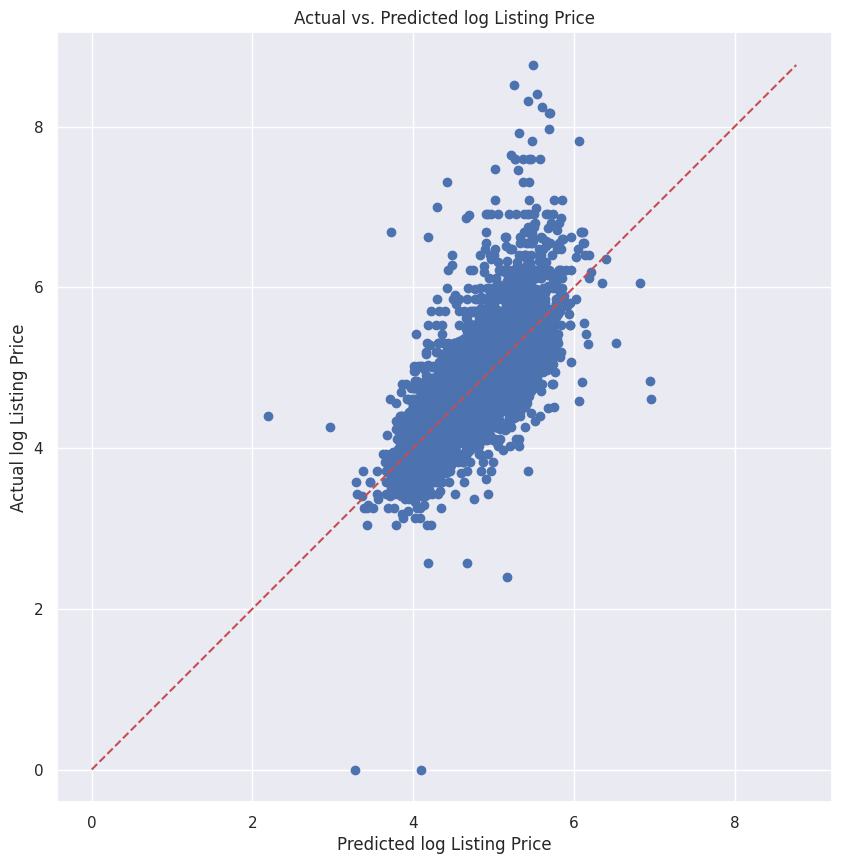

In [ ]:
# Plot LASSO prediction against actuals
plt.scatter(gb_tuned_pred_test, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Predicted log Listing Price')
plt.ylabel('Actual log Listing Price')
plt.title('Actual vs. Predicted log Listing Price')
plt.axis('equal')
plt.show()

The predicted vs actuals looks to align fairly well, with the exception of a heavy right tail skew on the actuals. This is not too surprising, as even the log normalized price showed a heavy right-tail skew on the distribution.

Now run the model one last time, but on all of the training data combined to get final performance metrics

In [ ]:
# Check performance against the full dataset
gb_tuned_pred_total = gb_model_tuned.predict(X)
gb_tuned_errors_total = y - gb_tuned_pred_total

# Run RMSE and R2 on test
gb_tuned_total_rmse = np.sqrt(mean_squared_error(y, gb_tuned_pred_total))
gb_tuned_total_r2 = r2_score(y, gb_tuned_pred_total)

print("GB Tuned Total RMSE: ",gb_tuned_total_rmse)
print("GB Tuned Total R2: ",gb_tuned_total_r2)

GB Tuned Total RMSE:  0.4371002053652276
GB Tuned Total R2:  0.6044431183941947
